In [9]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid #solve initial value problem, compute numerical integral
from scipy.linalg import null_space
from matplotlib import pyplot as plt
from IPython.display import display

# A complex stochastic system approaches equilibrium (arbitrary number of states) 

In [10]:
# Build a ladder of evenly spaced energy levels
energy_ladder = lambda energy_scale, number_of_states: np.linspace(energy_scale*1, energy_scale*number_of_states, number_of_states)

def arrhenius_transition_rate_matrix(energies, number_of_states, energy_barrier_difficulty=1.1, β=1, A=1): #for the equilibration regime
    # The energy barrier difficulty determines by what factor the barrier between two states is larger than the higher energy state between them
    #assuming β=1, A=1 for thermodynamic temperature and prefactor


    # Systematically define an energy barrier height, h, between two energy levels
    h = lambda ε1, ε2 : energy_barrier_difficulty * max(ε1, ε2)
    
    # Calculate the Arrhenius transition rate between two energy levels, going from ε1 to ε2
    arrhenius_rate = lambda ε1, ε2 : A * np.exp(-β*(h(ε1, ε2) - ε1))

    W = np.zeros(shape=(number_of_states, number_of_states))

    for i in range(number_of_states): # Row index
        for j in range(number_of_states): # Column index
            if i != j:  # Skip diagonal elements
                W[i, j] = arrhenius_rate(energies[i], energies[j]) # Transition rate going from state i to state j

    for k in range(number_of_states): # Diagonal index
        W[k, k] = -np.sum(W[:, k]) # Negative sum across the columns (Eq. 30 of Van den Broeck)
    
    return W
    

def random_initial_condition(number_of_states):

    weights = np.random.rand(number_of_states)
    normalized_probabilities = weights/np.sum(weights)

    return normalized_probabilities

In [11]:
def to_equilibrium_master_equation(time, probability_vector, transition_rate_matrix):
    
    W = transition_rate_matrix
    p = probability_vector
    dpdt = W @ p # This is the "master equation."
    
    return dpdt
    
def solve_master_equation_to_equilibrium(p_0, transition_rate_matrix, t_b, t_a=0, numtimes=100000):

    time_array = np.linspace(t_a, t_b, numtimes)
    solution = solve_ivp(fun=to_equilibrium_master_equation, t_span=[t_a, t_b], y0=p_0, t_eval=time_array, args=(transition_rate_matrix,))
    probability_vector_in_time = solution.y
    
    return time_array, probability_vector_in_time

In [12]:
N = 10 
end_time = 5.0

np.random.seed(1)
p0 = random_initial_condition(N)
energies = energy_ladder(energy_scale = 1, number_of_states=N)

many_states_matrix = arrhenius_transition_rate_matrix(energies, number_of_states=N, energy_barrier_difficulty=1.1)
print('Column sum is ', np.sum(many_states_matrix[:, 0])) # Check that sum of columns is zero
times, probabilities = solve_master_equation_to_equilibrium(p_0 = p0, transition_rate_matrix = many_states_matrix, t_b = end_time, t_a = 0)

Column sum is  -7.216449660063518e-16


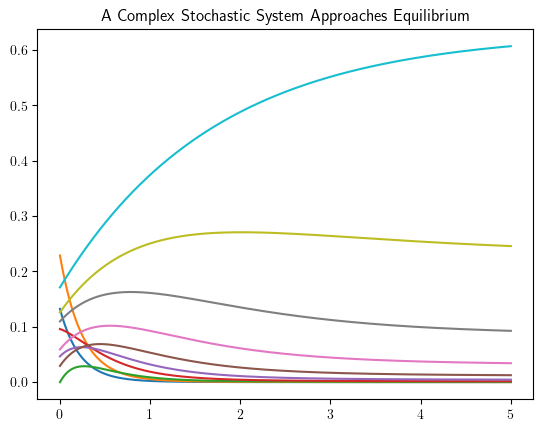

In [13]:
plt.title('A Complex Stochastic System Approaches Equilibrium')
plt.plot(times, probabilities.T)
plt.show()

# Stochastic First Law of Thermodynamics

The internal energy rate $\dot{U}= \frac{d}{dt}\sum_m p_m E_m$, with energy levels $E_m$, is given by

$$\dot{U} = \dot{Q} + \dot{W},$$

where $\dot{Q} = -\text{cov}(E, \dot{I})$ is the heat rate from the surprisal rate $I_m = -\ln p_m$ and the work rate is $\sum_m p_m \dot{E}_m$.

# Second Law of Thermodynamics

Equation 78 of Van den Broeck 2013 shows how to compute the entropy production rate:

$$\dot{S}_i = k_B \sum_{m, m'} W_{m, m'} p_{m'}\ln \frac{W_{m, m'} p_{m'}}{W_{m', m} p_m}$$

and Equation 79 shows how to compute the entropy flow rate:

$$\dot{S}_e = k_B \sum_{m, m'} W_{m, m'} p_{m'} \ln \frac{W_{m', m}}{W_{m, m'}}$$

In [14]:
def entropy_production_rate(W, p):
    # W is the transition rate matrix, p is the probability distribution
    S_dot_i = 0
    for i in range(len(p)): # Row index
        for j in range(len(p)): # Column index
            S_dot_i += W[i, j] * p[j] * np.log(W[i, j]*p[j] / W[j, i] / p[i])
    return S_dot_i

def entropy_flow_rate(W, p):
    # W is the transition rate matrix, p is the probability distribution
    S_dot_e = 0
    for i in range(len(p)): # Row index
        for j in range(len(p)): # Column index
            S_dot_e += W[i, j] * p[j] * np.log(W[j, i] / W[i, j])
    return S_dot_e

The second law is $\dot{S}_i \geq 0$, and the entropy rate is $\dot{S} = \dot{S}_i + \dot{S}_e$.

# Time-information uncertainty relation

The TIUR (Nicholson 2020) puts a speed limit on entropy via 
$$\sum_m p_m \left(\frac{d \ln p_m}{d t}\right)^2 = \mathcal{I}_{\mathcal{F}} \geq \frac{|\dot{S}|^2}{\sigma[I]^2},$$
where $\mathcal{I}_{\mathcal{F}}$ is Fisher information and $\sigma[I]$ is the standard deviation of surprisal $I=-\ln p$.

# Showing First Law, Second Law, and TIUR hold in this simulation

In [15]:
expectation_value = lambda probabilities, function_values: probabilities.dot(function_values)
covariance = lambda probabilities, function_values, gunction_values: expectation_value(probabilities, function_values*gunction_values) - expectation_value(probabilities, function_values)*expectation_value(probabilities, gunction_values)
variance = lambda probabilities, function_values: covariance(probabilities, function_values, gunction_values=function_values)

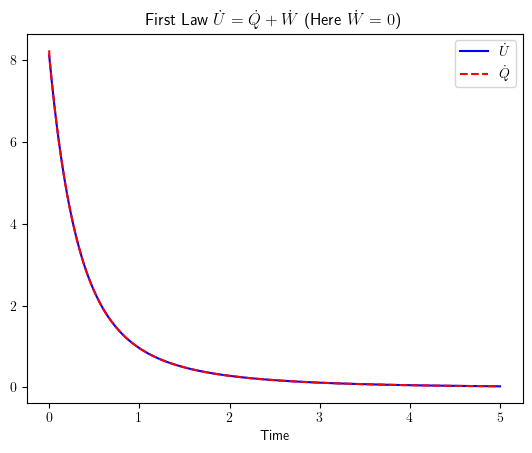

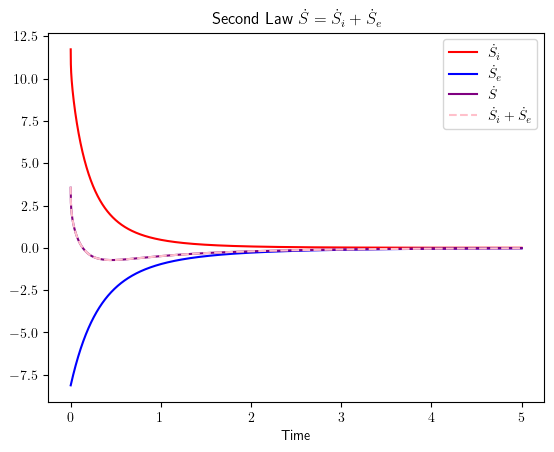

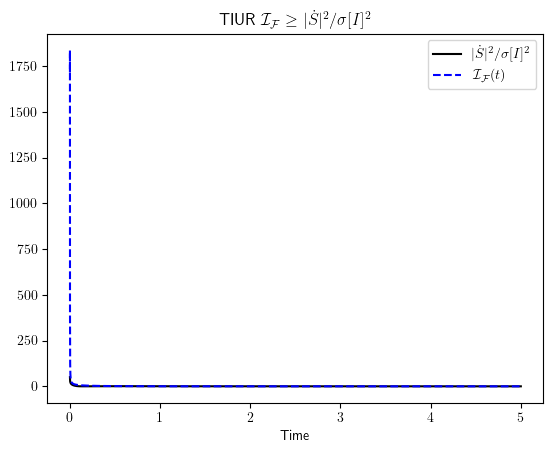

In [16]:
plt.rcParams['text.usetex'] = True
def compute_thermodynamics(time_series, probabilities, energy_levels, transition_rate_matrix, k_B=1, temperature=1):

    probability_rates = np.array([np.gradient(probability_series, time_series) for probability_series in probabilities]) 
    
    surprisals = -np.log(probabilities)
    surprisal_rates = np.array([np.gradient(surprisal_series, time_series) for surprisal_series in surprisals])

    internal_energy_series = np.array([expectation_value(probabilities.T[i], energy_levels) for i, t in enumerate(time_series)])
    entropy_series = np.array([expectation_value(probabilities.T[i], surprisals.T[i]) for i, _ in enumerate(time_series)])
    
    # Stochastic first law of thermodynamics
    internal_energy_rate_series = np.gradient(internal_energy_series, time_series)
    heat_rate_series = np.array([-covariance(probabilities.T[i], surprisal_rates.T[i], energy_levels) for i, t in enumerate(time_series)])
    # There is no mechanical work in this simulation.

    plt.plot(time_series, internal_energy_rate_series, color='blue', label=r'$\dot{U}$')
    plt.plot(time_series, heat_rate_series, linestyle='dashed', color='red', label=r'$\dot{Q}$')
    plt.title(r'First Law $\dot{U} = \dot{Q} + \dot{W}$ (Here $\dot{W}=0$)')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

    entropy_rate_series = np.gradient(entropy_series, time_series)
    entropy_production_rate_series = np.array([entropy_production_rate(W=transition_rate_matrix, p=p) for p in probabilities.T])
    entropy_flow_rate_series = np.array([entropy_flow_rate(W=transition_rate_matrix, p=p) for p in probabilities.T])

    plt.plot(time_series, entropy_production_rate_series, color='red', label=r'$\dot{S}_i$')
    plt.plot(time_series, entropy_flow_rate_series, color='blue', label=r'$\dot{S}_e$')
    plt.plot(time_series, entropy_rate_series, color='purple', label=r'$\dot{S}$')
    plt.plot(time_series, entropy_production_rate_series+entropy_flow_rate_series, linestyle='dashed', color='pink', label=r'$\dot{S}_i+\dot{S}_e$')
    plt.xlabel('Time')
    plt.legend()
    plt.title(r'Second Law $\dot{S}=\dot{S}_i + \dot{S}_e$')
    plt.show()
    
    # The Fisher information is a thermodynamic speed limit
    fisher_information_series = np.array([variance(probabilities.T[i], surprisal_rates.T[i]) for i, t in enumerate(time_series)])
    surprisal_variance_series = np.array([variance(probabilities.T[i], surprisals.T[i]) for i, t in enumerate(time_series)])

    plt.plot(time_series, entropy_rate_series**2 / surprisal_variance_series, color='black', label=r'$|\dot{S}|^2/\sigma[I]^2$')
    plt.plot(time_series, fisher_information_series, linestyle='dashed', color='blue', label=r'$\mathcal{I}_{\mathcal{F}}(t)$')
    plt.xlabel('Time')
    plt.legend()
    plt.title(r'TIUR $\mathcal{I}_{\mathcal{F}} \geq |\dot{S}|^2/\sigma[I]^2$')
    plt.show()
compute_thermodynamics(times, probabilities, energies, many_states_matrix)
    

# References 

1. Van den Broeck, C., 2013. Stochastic thermodynamics: A brief introduction. In Physics of Complex Colloids (pp. 155-193). IOS Press.
2. Nicholson, S.B., García-Pintos, L.P., del Campo, A. and Green, J.R., 2020. Time–information uncertainty relations in thermodynamics. Nature Physics, 16(12), pp.1211-1215
